# prep

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio
from tqdm import tqdm
from IPython.display import clear_output

import os
import pickle

%load_ext autoreload
%autoreload 2

In [3]:
local_flag = False
if local_flag:
    repo_dir = r'D:\repo\inter_data\inter'.replace("\\", "/") # under env dimred
else:
    repo_dir = r'C:\Users\ll357\Documents\inter'.replace("\\", "/")
os.chdir(repo_dir)
from src import adp

In [4]:
dir_inter = r'Z:\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
dir_file = os.path.join(dir_inter, 'adp_dataset_master.xlsx')
data_info = pd.read_excel(dir_file)
data_info.head()

meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'LM')
                 & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))] # ensure segmentation
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)

meta_LM = meta.copy()
meta_LM.tail()

LM    22
Name: area, dtype: int64 22


,mouse,date,area,depth,num,cellpose_seg,manual_seg,paradigm,gcamp,AWS,note
17,1373,230302,LM,200.0,3,1.0,NaN,grating,6s,NaN,NaN
18,1373,230302,LM,150.0,4,1.0,NaN,grating,6s,NaN,NaN
19,1381,230307,LM,200.0,2,1.0,NaN,grating,6s,NaN,NaN
20,1381,230307,LM,200.0,3,1.0,NaN,grating,6s,NaN,NaN
21,1381,230307,LM,150.0,4,1.0,NaN,grating,6s,NaN,NaN


In [5]:
meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'V1') 
                 & (data_info.gcamp == '6s') # avoid mixing in gcamp8f
                 & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))] # there are 2 data in V1 that haven't been segmented due to cellpose failing with low quality tiff
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)

meta_V1 = meta.copy()
meta_V1

V1    6
Name: area, dtype: int64 6


,mouse,date,area,depth,num,cellpose_seg,manual_seg,paradigm,gcamp,AWS,note
0,1323,200720,V1,200.0,3,NaN,True,grating,6s,1.0,NaN
1,1324,200728,V1,200.0,3,NaN,True,grating,6s,NaN,NaN
2,1322,200803,V1,200.0,2,NaN,True,grating,6s,NaN,NaN
3,1328,201015,V1,200.0,4,NaN,True,grating,6s,1.0,NaN
4,1329,201209,V1,200.0,2,NaN,True,grating,6s,NaN,NaN
5,1337,210120,V1,150.0,3,1.0,NaN,grating,6s,NaN,NaN


In [6]:
meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'LI') 
                 & (data_info.gcamp == '6s') # avoid mixing in gcamp8f
                 & (data_info.manual_seg != 'TODO')] # 2 LI data still need manual segm
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)

meta_LI = meta.copy()
meta_LI

LI    20
Name: area, dtype: int64 20


,mouse,date,area,depth,num,cellpose_seg,manual_seg,paradigm,gcamp,AWS,note
0,1323,200723,LI,200.0,3,NaN,True,grating,6s,1.0,NaN
1,1322,200806,LI,200.0,3,NaN,True,grating,6s,1.0,NaN
2,1328,201202,LI,200.0,3,NaN,True,grating,6s,1.0,NaN
3,1328,201202,LI,150.0,4,NaN,True,grating,6s,1.0,NaN
4,1329,210113,LI,200.0,4,NaN,RECHECK,grating,6s,NaN,"terrible timecourse by cellpose, must manual seg"
5,1329,210113,LI,150.0,6,NaN,RECHECK,grating,6s,NaN,NaN
6,1337,210203,LI,200.0,3,NaN,RECHECK,grating,6s,NaN,NaN
7,1337,210203,LI,150.0,4,NaN,RECHECK,grating,6s,NaN,NaN
8,1339,210930,LI,200.0,2,NaN,RECHECK,grating,6s,NaN,NaN
9,1339,210930,LI,150.0,3,NaN,RECHECK,grating,6s,NaN,NaN


# batch write df_tidy

In [279]:
meta = pd.concat([meta_V1, meta_LM, meta_LI], axis=0).reset_index(drop=True)
# meta = meta_LI.copy()
nset = len(meta)

for iset in tqdm(range(nset)):
    print(f'iset={iset}, nset={nset}')


    ## load data
    mouse = meta.loc[iset, 'mouse'].astype(str)
    imouse = 'i' + mouse
    date = meta.loc[iset, 'date'].astype(str)
    area = meta.loc[iset, 'area']
    sess = '00' + meta.loc[iset, 'num'].astype(str)
    print(mouse, date, area, sess)
    dir_identifier = f'{area}_{imouse}_{date}_{sess}'

    mat_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    for dirname in os.listdir(mat_inter):
        if dir_identifier in dirname:
            dir_data = mat_inter + dirname
            break

    stim_id, resp_ad, resp_tg = adp.load_resp_trial(os.path.join(dir_data), vis_filter=False) # already sliced by resp time window from matlab. only differentiating isi in resp_tg by indexing into trial. match isi_nframe
    ## NOTE: stim_id contains the final trial, which should be cut off due to incomplete trial, to match trace_by_trial


    ## construct dfof
    R1_dfof = resp_ad.flatten() # cell x trial, row major flatten
    R2_dfof = resp_tg.flatten()
    dfof = np.hstack((R1_dfof, R2_dfof)) # sort by cell_id, then trial_id, finally resp_id


    ## construct cell, trial, resp id
    ncell = resp_ad.shape[0]
    ntrial = resp_ad.shape[1]
    cell_id = np.repeat(np.arange(ncell), ntrial) # repeat cell id arr for ntrial times == sort by cell_id, then trial_id
    cell_id = np.hstack((cell_id, cell_id)) # stack two copies for R1 and R2. finally sort by resp_id

    trial_id = np.tile(np.arange(ntrial), ncell) # for each cell, go over all trials
    trial_id = np.hstack((trial_id, trial_id))

    len_df = ncell * ntrial * 2 # 2 for (R1, R2)
    resp_id = ['R1'] * int(len_df/2) + ['R2'] * int(len_df/2) # first half is flattened resp_ad, second half is flattened resp_tg


    ## construct stim info col: stim 2 orientation, stim 1 orien, isi, adapter contrast
    trial_stim_orien = [item[0] for item in stim_id['stim_ori']] # print(np.sort(np.unique(trial_stim_orien)))
    trial_stim_orien_dict = {} ## map stim2 orientation to int. convert from grat ori in deg to 0-based indexing (ensured)
    for i, item in enumerate(np.sort(np.unique(trial_stim_orien))):
        trial_stim_orien_dict[item] = i
    trial_stim_orien_int = [trial_stim_orien_dict[item] for item in trial_stim_orien]

    trial_isi_nframe = [item[0] for item in stim_id['isi_nframe']]
    trial_adapter_contrast = [item[0] for item in stim_id['adapter_contrast']]

    trial_stim_orien_int = trial_stim_orien_int[:ntrial] # if any stim info longer than ntrial, slice off the last one
    trial_isi_nframe = trial_isi_nframe[:ntrial]
    trial_adapter_contrast = trial_adapter_contrast[:ntrial]
    

    ## make stim info col: same as trial_id - tile then hstack
    stim_id_col = np.tile(trial_stim_orien_int, ncell)
    isi_col = np.tile(trial_isi_nframe, ncell)
    ad_con_col = np.tile(trial_adapter_contrast, ncell)

    stim_id_col = np.hstack((stim_id_col, stim_id_col)) # stim2 orientation
    isi_col = np.hstack((isi_col, isi_col))
    ad_con_col = np.hstack((ad_con_col, ad_con_col))

    df_tidy = pd.DataFrame({'dfof': dfof, 'cell_id': cell_id, 'trial_id': trial_id, 'resp_id': resp_id, 
                            'isi': isi_col, 'stim1_contrast': ad_con_col, 
                            'stim2_id': stim_id_col,})
    df_tidy['area'] = area
    df_tidy['stim1_id'] = 0 # adapter (stim1) is always 0 deg / vertical gratings
    df_tidy.loc[(df_tidy.stim1_contrast == 0) & (df_tidy.resp_id == 'R1'), 'dfof'] = np.nan # set R1 to nan if no adapter (stim1_contrast == 0)
    df_tidy = df_tidy.dropna().reset_index(drop=True) # drop nan rows

    df_tidy['isi'] = df_tidy['isi'].apply(lambda x: 250 if x <= 10 else 750) # convert isi_nframe to ms. 250 ms is about 8 frames, 750 ms is about 22-23 frames
    df_tidy.loc[df_tidy.stim1_contrast == 0, 'isi'] = 6000 # set ISI to 6000 ms (equal to ITI) if no adapter (stim1_contrast == 0)


    ## vis cell filter, well_fit filter, & img driven cell-stim filter
    df_tidy['filter_cell_vis'] = np.nan
    df_tidy['filter_cell_well_fit'] = np.nan
    df_tidy['filter_cell_stim'] = np.nan

    with open(os.path.join(dir_data, 'vis_driven.pickle'), 'rb') as f:
        filter_file = pickle.load(f)
    filter_cell_stim = filter_file['img_driven']
    filter_cell_vis = filter_file['vis_driven']

    well_fit = sio.loadmat(os.path.join(dir_data, 'fit_bootstrap_90perc.mat'))
    well_fit_cell = np.array([x[0] for x in well_fit['well_fit_cell']])

    for icell in np.arange(filter_cell_stim.shape[0]): # filter_cell_stim is ncell x nstim
        df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_vis'] = filter_cell_vis[icell][0] # filter_cell_vis is a list of list
        df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_well_fit'] = well_fit_cell[icell]
        for istim in np.arange(filter_cell_stim.shape[1]):
            df_tidy.loc[(df_tidy['stim2_id']==istim) & (df_tidy['cell_id']==icell), 'filter_cell_stim'] = filter_cell_stim[icell, istim]
    # df_tidy.filter_cell_vis.value_counts(), df_tidy.filter_cell_stim.value_counts()


    ## cell tuning in 3 possible ISI, 2 runs (each run uses half of the trials)
    fit_tuning_half = sio.loadmat(os.path.join(dir_data, 'fit_tuning_half_trials.mat'))
    ori_pref_run1 = fit_tuning_half['ori_pref_runs'][:, :, 0] # ncell x 3isi x 2run, [noad vs ad750 vs ad250]
    ori_pref_run2 = fit_tuning_half['ori_pref_runs'][:, :, 1]

    # ori_pref_runs_sorted = well_fit['ori_pref_runs']
    # # ori_pref_runs_sorted = np.array([np.sort(x) for x in well_fit['ori_pref_runs']]) # ncell x nrun. sort each row of ori_pref_runs
    # # for icell in np.arange(10):
    # #     plt.plot(ori_pref_runs_sorted[icell, :])

    # percentile_threshold = 0.9
    # # if area == 'LI':
    # #     percentile_threshold = 0.7 # taken from well_fit_cell_criteria(_relax).m, only relax for LI
    # nrun = ori_pref_runs_sorted.shape[1]
    # rand_idx = np.random.randint(nrun*(1-percentile_threshold), nrun*percentile_threshold, size=2) # # bc well_fit cells are defined as: 90% of bootstrapped ori_pref within 22.5 deg, randomly select 2 indices between 100-900 in ori_pref_runs_sorted
    # ori_pref_noad1 = ori_pref_runs_sorted[:, rand_idx[0]] # ncell x 1
    # ori_pref_noad2 = ori_pref_runs_sorted[:, rand_idx[1]]


    ## goodness of fit (R square) in isi 250 or 750
    fit_tuning = sio.loadmat(os.path.join(dir_data, 'fit_tuning_isi3.mat')) # fit_tuning['fit_param'].shape # ncell x nparam x nstim
    R_square = fit_tuning['fit_param'][:, -1, :] # ncell x nstim, final param is R_square of fit
    R_square_750 = R_square[:, 1] # use R_sq to determine well_fit_ad
    R_square_250 = R_square[:, 2]
    well_fit_ad_250 = R_square_250 >= np.percentile(R_square_250, 50) # ncell x 1. only take top 50% of R_sq
    well_fit_ad_750 = R_square_750 >= np.percentile(R_square_750, 50)


    ## write cell property to df_tidy
    ncell = df_tidy.cell_id.unique().shape[0]
    for icell in np.arange(ncell):
        df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_noad'] = ori_pref_run1[icell, 0] # ori_pref_run1 is ncell x 3isi, [noad vs ad750 vs ad250]
        df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_ad_750'] = ori_pref_run1[icell, 1]
        df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_ad_250'] = ori_pref_run1[icell, 2]

        df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_noad1'] = ori_pref_run1[icell, 0] # for control plot. ori_pref_noad1 is same as ori_pref_noad
        df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_noad2'] = ori_pref_run2[icell, 0] # take from another run

        df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_well_fit_ad_250'] = well_fit_ad_250[icell]
        df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_well_fit_ad_750'] = well_fit_ad_750[icell]
    
    # break

    ## save df_tidy as csv
#     df_tidy.to_csv(os.path.join(dir_data, 'df_tidy_fit_tuning_half_trials.csv'), index=False)

# clear_output()

  0%|          | 0/48 [00:00<?, ?it/s]

iset=0, nset=48
1323 200720 V1 003


  0%|          | 0/48 [00:02<?, ?it/s]

ncell: 103, nstim: 8, ntrial: 463


In [288]:
trial_stim_orien = [item[0] for item in stim_id['stim_ori']] # print(np.sort(np.unique(trial_stim_orien)))
np.max(trial_stim_orien), np.min(trial_stim_orien)

trial_stim_orien_dict = {} ## map stim2 orientation to int
for i, item in enumerate(np.sort(np.unique(trial_stim_orien))):
    trial_stim_orien_dict[item] = i
trial_stim_orien_dict

trial_stim_orien_int = [trial_stim_orien_dict[item] for item in trial_stim_orien]
trial_stim_orien_int[:10], trial_stim_orien[:10]

([5, 2, 2, 3, 2, 0, 7, 5, 4, 4],
 [112.5, 45.0, 45.0, 67.5, 45.0, 0.0, 157.5, 112.5, 90.0, 90.0])

# batch load df_tidy

In [252]:
meta = pd.concat([meta_V1, meta_LM, meta_LI], axis=0).reset_index(drop=True)
# meta = meta_LI.copy()
# meta.sample(5, random_state=0)
meta

,mouse,date,area,depth,num,cellpose_seg,manual_seg,paradigm,gcamp,AWS,note
0,1323,200720,V1,200.0,3,NaN,True,grating,6s,1.0,NaN
1,1324,200728,V1,200.0,3,NaN,True,grating,6s,NaN,NaN
2,1322,200803,V1,200.0,2,NaN,True,grating,6s,NaN,NaN
3,1328,201015,V1,200.0,4,NaN,True,grating,6s,1.0,NaN
4,1329,201209,V1,200.0,2,NaN,True,grating,6s,NaN,NaN
5,1337,210120,V1,150.0,3,1.0,NaN,grating,6s,NaN,NaN
6,1323,200721,LM,200.0,2,NaN,True,grating,6s,1.0,NaN
7,1324,200729,LM,200.0,3,NaN,True,grating,6s,1.0,NaN
8,1322,200804,LM,200.0,3,NaN,True,grating,6s,1.0,NaN
9,1328,201119,LM,200.0,3,NaN,True,grating,6s,1.0,NaN


In [8]:
nset = len(meta)
df_tidy = pd.DataFrame()

for iset in range(nset):
    print(f'iset={iset}, nset={nset}')

    mouse = meta.loc[iset, 'mouse'].astype(str)
    imouse = 'i' + mouse
    date = meta.loc[iset, 'date'].astype(str)
    area = meta.loc[iset, 'area']
    sess = '00' + meta.loc[iset, 'num'].astype(str)
    print(imouse, date, area, sess)
    dir_identifier = f'{area}_{imouse}_{date}_{sess}'

    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    csv_filename = 'df_tidy_fit_tuning_half_trials.csv'
    try:
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))
    except:
        dir_identifier = dir_identifier + '_cellpose'
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))

    df_tidy_now['mouse'] = mouse
    df_tidy_now['date'] = date
    df_tidy_now['sess'] = sess
    df_tidy_now['cell_id'] = (df_tidy_now.date.astype(str) + '_' 
                               + df_tidy_now.sess.astype(str) + '_' 
                               + df_tidy_now.cell_id.astype(str)) # cell_id adjusted to be unique across mice, dates, sessions
    df_tidy = pd.concat([df_tidy, df_tidy_now], axis=0).reset_index(drop=True)
    # break
    
clear_output()

In [9]:
print(df_tidy.mouse.unique(), 
      df_tidy.date.unique(), 
      df_tidy.sess.unique(), 
      df_tidy.area.unique(), 
      df_tidy.isi.unique(), 
      df_tidy.stim1_contrast.unique(), 
      df_tidy.stim2_id.unique(), 
      df_tidy.resp_id.unique())
df_tidy.sample(5, random_state=0)

['1323' '1324' '1322' '1328' '1329' '1337' '1338' '1350' '1351' '1380'
 '1373' '1381' '1339' '1374'] ['200720' '200728' '200803' '201015' '201209' '210120' '200721' '200729'
 '200804' '201119' '201127' '201217' '210127' '210325' '210805' '211020'
 '220228' '230221' '230302' '230307' '200723' '200806' '201202' '210113'
 '210203' '210930' '211028' '230110' '230228' '230309' '230323'] ['003' '002' '004' '006'] ['V1' 'LM' 'LI'] [ 750  250 6000] [1 0] [5 2 3 0 7 4 1 6] ['R1' 'R2']


,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,...,ori_pref_noad,ori_pref_ad_750,ori_pref_ad_250,ori_pref_noad1,ori_pref_noad2,filter_cell_well_fit_ad_250,filter_cell_well_fit_ad_750,mouse,date,sess
2522359,0.064808,230323_003_32,8,R1,250,1,5,LI,0,False,...,45.000000,162.527850,60.088142,45.000000,179.737029,False,True,1374,230323,003
1603041,-0.010087,230302_004_128,272,R2,250,1,3,LM,0,True,...,170.290328,0.287615,172.995644,170.290328,165.619769,True,False,1373,230302,004
1370059,-0.063766,230221_003_34,411,R2,6000,0,6,LM,0,False,...,33.334788,135.000000,35.490009,33.334788,67.409489,False,True,1380,230221,003
2385126,-0.017126,230309_002_90,111,R2,250,1,3,LI,0,True,...,45.000000,84.508480,44.297625,45.000000,56.171587,True,True,1381,230309,002
123632,0.047451,200728_003_27,433,R2,6000,0,3,V1,0,True,...,95.956393,98.629334,95.660354,95.956393,89.631448,True,True,1324,200728,003


# adaptation by area

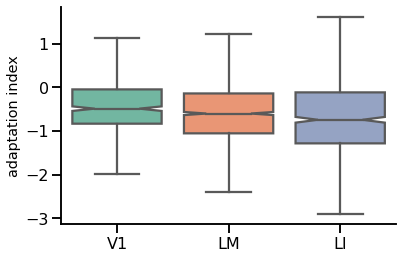

In [28]:
def adp_in_area(df_filter):

    gb_R1 = df_filter[(df_filter.stim2_id == 0) & (df_filter.resp_id == 'R1')].groupby(['area', 'cell_id']).sum()['dfof'].values
    gb_R2 = df_filter[(df_filter.stim2_id == 0) & (df_filter.resp_id == 'R2')].groupby(['area', 'cell_id']).sum()['dfof'].values
    gb_adp = (gb_R2 - gb_R1) / (gb_R1 + 1e-7)
    gb_adp = gb_adp[np.abs(gb_adp) < 5]

    return gb_adp

df_filter = df_tidy[df_tidy.isi == 250]
gb_adp_V1 = adp_in_area(df_filter[df_filter.area == 'V1'])
gb_adp_LM = adp_in_area(df_filter[df_filter.area == 'LM'])
gb_adp_LI = adp_in_area(df_filter[df_filter.area == 'LI'])

# plt.hist(gb_adp_V1, bins=50, alpha=.5, label='V1')
# plt.hist(gb_adp_LM, bins=50, alpha=.5, label='LM')
# plt.hist(gb_adp_LI, bins=50, alpha=.5, label='LI')
# plt.legend();

# adp_mean_arr = [np.mean(gb_adp_V1), np.mean(gb_adp_LM), np.mean(gb_adp_LI)]
# adp_med_arr = [np.median(gb_adp_V1), np.median(gb_adp_LM), np.median(gb_adp_LI)]
# adp_sem_arr = [np.std(gb_adp_V1) / np.sqrt(len(gb_adp_V1)), 
#                np.std(gb_adp_LM) / np.sqrt(len(gb_adp_LM)),
#                 np.std(gb_adp_LI) / np.sqrt(len(gb_adp_LI))]
# plt.errorbar([1, 2, 3], adp_mean_arr, yerr=adp_sem_arr, label='mean', alpha=.5)
# plt.errorbar([1, 2, 3], adp_med_arr, yerr=adp_sem_arr, label='median', alpha=.5)
# plt.xticks([1, 2, 3], ['V1', 'LM', 'LI']);
# plt.ylim([-1, 0]);
# plt.legend(frameon=False);

sns.boxplot(data=[gb_adp_V1, gb_adp_LM, gb_adp_LI], palette='Set2', notch=True, showfliers=False) # dont show the outliers beyond the caps
plt.xticks([0, 1, 2], ['V1', 'LM', 'LI']);
plt.ylabel('adaptation index');
sns.despine();

dir_fig = r'C:\Users\ll357\Documents\inter\results\tuning bias'.replace('\\', '/')
# plt.savefig(os.path.join(dir_fig, 'adp_grat8_by_area.pdf'))

# tuning bias preprocessing
x: distance(pref_ori_unadapted, 0 deg adapter_ori).binned  
y: distance(pref_ori_unadapted, 0 deg) - distance(pref_ori_adapted, 0 deg)

## pref_ori for cell & isi
~~crude preference: take max-resp orientation as the preferred orien~~  
fitted preference: use pref from von mises curve fit

In [29]:
def bin_ori(x):
    # bin pref ori to 0, 45, 90
    if x < 30:
        return 0
    elif x <= 60:
        return 45
    else:
        return 90

def bin_ori_finer(x):
    # bin pref ori to n bins, with equal bin width
    nbin = 4 # n_edge = nbin + 1
    bin_width = 90 / nbin
    return (x // bin_width) * bin_width

def distance_from_adapter(x):
    # adapter is always 0 deg
    # x = 22.5*x # convert from stim id int to degree
    if x > 90:
        x = 180 - x
    return x


df_tidy['pref_unadapted_distance'] = df_tidy['ori_pref_noad'].apply(lambda x: distance_from_adapter(x)) # unadapted pref ori, distance from adapter
df_tidy['pref_unadapted_distance_bin'] = df_tidy['pref_unadapted_distance'].apply(lambda x: bin_ori(x)) # bin the distance to 0, 45, 90
# df_tidy['pref_unadapted_distance_bin'] = df_tidy['pref_unadapted_distance'].apply(lambda x: bin_ori_finer(x)) # bin the distance to 5 edges, 0, 22.5, 45, 67.5, 90

df_tidy.loc[(df_tidy.isi == 250), 'pref_adapted_distance'] = df_tidy['ori_pref_ad_250'].apply(lambda x: distance_from_adapter(x)) # isi 250 adapted pref ori, distance from adapter # TODO: refactor pref_ori_ad_250 similarly, so it's only one column of pref_ori_ad, but can filter by isi
df_tidy.loc[(df_tidy.isi == 750), 'pref_adapted_distance'] = df_tidy['ori_pref_ad_750'].apply(lambda x: distance_from_adapter(x)) # isi 750 adapted pref ori, distance from adapter
df_tidy['tuning_bias'] = df_tidy['pref_adapted_distance'] - df_tidy['pref_unadapted_distance'] # distance from adapter, adapted - unadapted. if tuning repelled from adapter, this is positive; attracted, negative

df_tidy.sample(5, random_state=0)

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,...,ori_pref_noad2,filter_cell_well_fit_ad_250,filter_cell_well_fit_ad_750,mouse,date,sess,pref_unadapted_distance,pref_unadapted_distance_bin,pref_adapted_distance,tuning_bias
2522359,0.064808,230323_003_32,8,R1,250,1,5,LI,0,False,...,179.737029,False,True,1374,230323,003,45.000000,45,60.088142,15.088142
1603041,-0.010087,230302_004_128,272,R2,250,1,3,LM,0,True,...,165.619769,True,False,1373,230302,004,9.709672,0,7.004356,-2.705316
1370059,-0.063766,230221_003_34,411,R2,6000,0,6,LM,0,False,...,67.409489,False,True,1380,230221,003,33.334788,45,NaN,NaN
2385126,-0.017126,230309_002_90,111,R2,250,1,3,LI,0,True,...,56.171587,True,True,1381,230309,002,45.000000,45,44.297625,-0.702375
123632,0.047451,200728_003_27,433,R2,6000,0,3,V1,0,True,...,89.631448,True,True,1324,200728,003,84.043607,90,NaN,NaN


In [30]:
df_control = df_tidy.copy()

df_control['pref_unadapted_distance'] = df_control['ori_pref_noad1'].apply(lambda x: distance_from_adapter(x)) # unadapted pref ori, distance from adapter
df_control['pref_unadapted_distance_bin'] = df_control['pref_unadapted_distance'].apply(lambda x: bin_ori(x)) # bin the distance to 0, 45, 90
# df_control['pref_unadapted_distance_bin'] = df_control['pref_unadapted_distance'].apply(lambda x: bin_ori_finer(x))

df_control['pref_adapted_distance'] = df_control['ori_pref_noad2'].apply(lambda x: distance_from_adapter(x))
df_control['tuning_bias'] = df_control['pref_adapted_distance'] - df_control['pref_unadapted_distance']

df_control.sample(5, random_state=0)

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,...,ori_pref_noad2,filter_cell_well_fit_ad_250,filter_cell_well_fit_ad_750,mouse,date,sess,pref_unadapted_distance,pref_unadapted_distance_bin,pref_adapted_distance,tuning_bias
2522359,0.064808,230323_003_32,8,R1,250,1,5,LI,0,False,...,179.737029,False,True,1374,230323,003,45.000000,45,0.262971,-44.737029
1603041,-0.010087,230302_004_128,272,R2,250,1,3,LM,0,True,...,165.619769,True,False,1373,230302,004,9.709672,0,14.380231,4.670560
1370059,-0.063766,230221_003_34,411,R2,6000,0,6,LM,0,False,...,67.409489,False,True,1380,230221,003,33.334788,45,67.409489,34.074701
2385126,-0.017126,230309_002_90,111,R2,250,1,3,LI,0,True,...,56.171587,True,True,1381,230309,002,45.000000,45,56.171587,11.171587
123632,0.047451,200728_003_27,433,R2,6000,0,3,V1,0,True,...,89.631448,True,True,1324,200728,003,84.043607,90,89.631448,5.587841


## merge df real vs control

In [118]:
assert len(df_tidy) == len(df_control) # same number of rows
assert (df_tidy.columns == df_control.columns).all() # all columns are the same
assert np.sum(df_control['pref_unadapted_distance_bin'].values == df_tidy['pref_unadapted_distance_bin'].values) == len(df_tidy) # same pref_unadapted_distance_bin due to ori_pref_noad1 == ori_pref_noad
assert np.sum(df_tidy.tuning_bias.values == df_control.tuning_bias.values) < len(df_tidy) # different tuning bias
print('for tuning bias plot, only tuning bias col differs between control and real df')

for tuning bias plot, only tuning bias col differs between control and real df


In [119]:
df_tidy['tuning_bias_control'] = df_control['tuning_bias']
df_tidy

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,...,filter_cell_well_fit_ad_250,filter_cell_well_fit_ad_750,mouse,date,sess,pref_unadapted_distance,pref_unadapted_distance_bin,pref_adapted_distance,tuning_bias,tuning_bias_control
0,-0.003253,200720_003_0,0,R1,750,1,5,V1,0,True,...,True,True,1323,200720,003,73.675005,90,71.987028,-1.687976,2.857408
1,0.088726,200720_003_0,1,R1,250,1,2,V1,0,True,...,True,True,1323,200720,003,73.675005,90,71.465895,-2.209110,2.857408
2,-0.010485,200720_003_0,2,R1,250,1,2,V1,0,True,...,True,True,1323,200720,003,73.675005,90,71.465895,-2.209110,2.857408
3,-0.050493,200720_003_0,3,R1,750,1,3,V1,0,True,...,True,True,1323,200720,003,73.675005,90,71.987028,-1.687976,2.857408
4,0.052611,200720_003_0,5,R1,750,1,0,V1,0,True,...,True,True,1323,200720,003,73.675005,90,71.987028,-1.687976,2.857408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2566530,0.056616,230323_003_64,496,R2,6000,0,5,LI,0,False,...,False,False,1374,230323,003,15.044770,0,NaN,NaN,52.021868
2566531,0.077247,230323_003_64,497,R2,6000,0,6,LI,0,False,...,False,False,1374,230323,003,15.044770,0,NaN,NaN,52.021868
2566532,0.026982,230323_003_64,498,R2,250,1,6,LI,0,False,...,False,False,1374,230323,003,15.044770,0,68.311464,53.266694,52.021868
2566533,-0.069060,230323_003_64,499,R2,6000,0,7,LI,0,False,...,False,False,1374,230323,003,15.044770,0,NaN,NaN,52.021868


## save & reload

In [10]:
dir_df = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\df tidy for plots/'.replace('\\', '/')
csv_filename = 'df_tidy_tuning_bias_diff.csv'

# chunks = np.array_split(df_tidy.index, 100) # split into 100 chunks
# for chunk, subset in enumerate(tqdm(chunks)):
#     if chunk == 0: # first row
#         df_tidy.loc[subset].to_csv(csv_filename, mode='w', index=True)
#     else:
#         df_tidy.loc[subset].to_csv(csv_filename, header=None, mode='a', index=True)

df_tidy = pd.read_csv(os.path.join(dir_df, csv_filename), index_col=0) # this results from taking only half trials when fitting or noad-control

In [56]:
df_tidy

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,...,filter_cell_well_fit_ad_250,filter_cell_well_fit_ad_750,mouse,date,sess,pref_unadapted_distance,pref_unadapted_distance_bin,pref_adapted_distance,tuning_bias,tuning_bias_control
0,-0.003253,200720_003_0,0,R1,750,1,5,V1,0,True,...,True,True,1323,200720,3,73.675005,90,71.987028,-1.687976,2.857408
1,0.088726,200720_003_0,1,R1,250,1,2,V1,0,True,...,True,True,1323,200720,3,73.675005,90,71.465895,-2.209110,2.857408
2,-0.010485,200720_003_0,2,R1,250,1,2,V1,0,True,...,True,True,1323,200720,3,73.675005,90,71.465895,-2.209110,2.857408
3,-0.050493,200720_003_0,3,R1,750,1,3,V1,0,True,...,True,True,1323,200720,3,73.675005,90,71.987028,-1.687976,2.857408
4,0.052611,200720_003_0,5,R1,750,1,0,V1,0,True,...,True,True,1323,200720,3,73.675005,90,71.987028,-1.687976,2.857408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2566530,0.056616,230323_003_64,496,R2,6000,0,5,LI,0,False,...,False,False,1374,230323,3,15.044770,0,NaN,NaN,52.021868
2566531,0.077247,230323_003_64,497,R2,6000,0,6,LI,0,False,...,False,False,1374,230323,3,15.044770,0,NaN,NaN,52.021868
2566532,0.026982,230323_003_64,498,R2,250,1,6,LI,0,False,...,False,False,1374,230323,3,15.044770,0,68.311464,53.266694,52.021868
2566533,-0.069060,230323_003_64,499,R2,6000,0,7,LI,0,False,...,False,False,1374,230323,3,15.044770,0,NaN,NaN,52.021868


## if use all trials, not half trials

In [31]:
df_tidy_all_trials = pd.read_csv(os.path.join(dir_df, 'df_tidy_tuning_bias.csv'), index_col=0)
df_tidy_control_all_trials = pd.read_csv(os.path.join(dir_df, 'df_tidy_tuning_bias_control.csv'), index_col=0)

In [36]:
assert len(df_tidy_all_trials) == len(df_tidy_control_all_trials) # same number of rows
assert (df_tidy_all_trials.columns == df_tidy_control_all_trials.columns).all() # all columns are the same
# assert np.sum(df_tidy_control_all_trials['pref_unadapted_distance_bin'].values == df_tidy_all_trials['pref_unadapted_distance_bin'].values) == len(df_tidy_all_trials) # same pref_unadapted_distance_bin due to ori_pref_noad1 == ori_pref_noad
assert np.sum(df_tidy_all_trials.tuning_bias.values == df_tidy_control_all_trials.tuning_bias.values) < len(df_tidy_all_trials) # different tuning bias
print('for tuning bias plot, only tuning bias and pref_unadapted_distance_bin differs between control and real df')
df_tidy_all_trials['tuning_bias_control'] = df_tidy_control_all_trials['tuning_bias']
df_tidy_all_trials['pref_unadapted_distance_bin_control'] = df_tidy_control_all_trials['pref_unadapted_distance_bin']
df_tidy_all_trials

for tuning bias plot, only tuning bias and pref_unadapted_distance_bin differs between control and real df


,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,filter_cell_well_fit,...,filter_cell_well_fit_ad_750,mouse,date,sess,pref_unadapted_distance,pref_unadapted_distance_bin,pref_adapted_distance,tuning_bias,tuning_bias_control,pref_unadapted_distance_bin_control
dfof,,,,,,,,,,,,,,,,,,,,,
-0.003253,200720_003_0,0,R1,750,1,5,V1,0,True,1.0,...,True,1323,200720,3,82.347391,90,73.637094,-8.710298,-1.662357,90
0.088726,200720_003_0,1,R1,250,1,2,V1,0,True,1.0,...,True,1323,200720,3,82.347391,90,68.247541,-14.099850,-1.662357,90
-0.010485,200720_003_0,2,R1,250,1,2,V1,0,True,1.0,...,True,1323,200720,3,82.347391,90,68.247541,-14.099850,-1.662357,90
-0.050493,200720_003_0,3,R1,750,1,3,V1,0,True,1.0,...,True,1323,200720,3,82.347391,90,73.637094,-8.710298,-1.662357,90
0.052611,200720_003_0,5,R1,750,1,0,V1,0,True,1.0,...,True,1323,200720,3,82.347391,90,73.637094,-8.710298,-1.662357,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.056616,230323_003_64,496,R2,6000,0,5,LI,0,False,0.0,...,False,1374,230323,3,7.524045,0,NaN,NaN,32.539719,0
0.077247,230323_003_64,497,R2,6000,0,6,LI,0,False,0.0,...,False,1374,230323,3,7.524045,0,NaN,NaN,32.539719,0
0.026982,230323_003_64,498,R2,250,1,6,LI,0,False,0.0,...,False,1374,230323,3,7.524045,0,31.946264,24.422218,32.539719,0


In [40]:
df_filter = df_tidy_all_trials[(df_tidy_all_trials.trial_id > -1) # placeholder, always true
                            & (df_tidy_all_trials.filter_cell_vis == True)
                            & (df_tidy_all_trials.filter_cell_well_fit == True)
                            & (df_tidy_all_trials.isi == 250)
                            ]
df_filter = df_filter.groupby('cell_id')[['area', 'pref_unadapted_distance_bin', 'pref_unadapted_distance_bin_control', 'tuning_bias', 'tuning_bias_control']].first().reset_index()
df_filter['tuning_bias_diff'] = df_filter['tuning_bias'] - df_filter['tuning_bias_control']
df_filter

,cell_id,area,pref_unadapted_distance_bin,pref_unadapted_distance_bin_control,tuning_bias,tuning_bias_control,tuning_bias_diff
0,200720_003_0,V1,90,90,-14.099850,-1.662357,-12.437493
1,200720_003_2,V1,90,90,-6.375618,0.529648,-6.905266
2,200720_003_22,V1,90,90,7.036726,0.703476,6.333250
3,200720_003_24,V1,0,0,14.101941,2.149425,11.952516
4,200720_003_25,V1,90,90,6.757597,1.970022,4.787575
...,...,...,...,...,...,...,...
632,230307_004_26,LM,0,0,4.357937,-8.113508,12.471445
633,230307_004_45,LM,45,45,-30.671126,5.708120,-36.379246
634,230307_004_47,LM,0,0,-15.573513,-7.068267,-8.505246
635,230309_002_44,LI,90,90,-50.296272,-1.398636,-48.897635


### tuning bias plot (all trials)

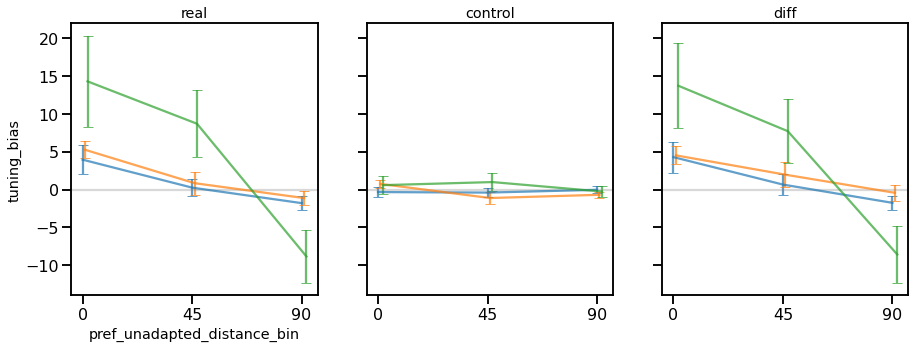

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
jitter = 1
for i, iarea in enumerate(df_filter.area.unique()):
    axes[0].errorbar(x=np.array(sorted(df_filter[df_filter.area == iarea].pref_unadapted_distance_bin.unique())) + i * jitter,
                    y=df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias.mean(), 
                    yerr=df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias.sem(), 
                    capsize=5, alpha=.7)


    axes[1].errorbar(x=np.array(sorted(df_filter[df_filter.area == iarea].pref_unadapted_distance_bin_control.unique())) + i * jitter,
                    y=df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias_control.mean(),
                    yerr=df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias_control.sem(),
                    capsize=5, alpha=.7)
    
    axes[2].errorbar(x=np.array(sorted(df_filter[df_filter.area == iarea].pref_unadapted_distance_bin.unique())) + i * jitter,
                    y=df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias.mean() - df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias_control.mean(),
                    yerr=df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias_diff.sem(),
                    capsize=5, alpha=.7)

axes[0].axhline(0, color='gray', linestyle='-', alpha=.3);
axes[1].axhline(0, color='gray', linestyle='-', alpha=.3);
axes[2].axhline(0, color='gray', linestyle='-', alpha=.3);

axes[0].set_title('real')
axes[0].set_xlabel('pref_unadapted_distance_bin')
axes[0].set_ylabel('tuning_bias')
axes[0].set_xticks([0, 45, 90])
axes[0].set_xticklabels([0, 45, 90])

axes[1].set_title('control');
axes[1].set_xticks([0, 45, 90])
axes[1].set_xticklabels([0, 45, 90])

axes[2].set_title('diff');
axes[2].set_xticks([0, 45, 90])
axes[2].set_xticklabels([0, 45, 90]);

### stats sig

In [50]:
pref_unadapted_distance_bin = 90
data = np.array([
                df_filter[(df_filter.area == 'V1') & (df_filter.pref_unadapted_distance_bin == pref_unadapted_distance_bin)].tuning_bias_diff.values,
                df_filter[(df_filter.area == 'LM') & (df_filter.pref_unadapted_distance_bin == pref_unadapted_distance_bin)].tuning_bias_diff.values,
                df_filter[(df_filter.area == 'LI') & (df_filter.pref_unadapted_distance_bin == pref_unadapted_distance_bin)].tuning_bias_diff.values,
                ], dtype=object)
data.shape, data[0].shape, data[1].shape, data[2].shape

((3,), (85,), (172,), (20,))

In [51]:
## t test
from scipy.stats import ttest_ind

## assumption: equal variance
print(np.var(data[0]), np.var(data[1]),) # assumption not met

t, p = ttest_ind(data[0], data[1], equal_var=False, alternative='less') #, permutations=10000, random_state=0)
t, p

71.34761782293795 185.11324610274514


(-0.9513678466644974, 0.17118402305896058)

In [52]:
## one way ANOVA
from scipy.stats import f_oneway

## assumption: equal variance
print(np.var(data[0]), np.var(data[1]), np.var(data[2]))
## assumption: normality
from scipy.stats import shapiro
print(shapiro(data[0]).pvalue, shapiro(data[1]).pvalue, shapiro(data[2]).pvalue)

f_oneway(data[0], data[1], data[2])

71.34761782293795 185.11324610274514 263.0468090748901
4.286658281671407e-07 1.632584685658505e-14 0.0015573829878121614


F_onewayResult(statistic=3.801247822372638, pvalue=0.023530258467825266)

In [53]:
from scipy.stats import kruskal
kruskal(data[0], data[1], data[2])

KruskalResult(statistic=9.896509703989182, pvalue=0.007095781318701659)

# tuning bias plot

In [270]:
df_filter = df_tidy[(df_tidy.trial_id > -1) # placeholder, always true
                    & (df_tidy.filter_cell_vis == True)
                  #   & (df_tidy.filter_cell_stim == True)
                    & (df_tidy.filter_cell_well_fit == True)
                    # & (df_tidy.filter_cell_well_fit_ad_250 == True)
                    & (df_tidy.isi == 250)
                    # & (df_tidy.filter_cell_well_fit_ad_750 == True)
                    # & (df_tidy.isi == 750)
                    ]
df_filter = df_filter.groupby('cell_id')[['area', 'pref_unadapted_distance_bin', 'tuning_bias', 'tuning_bias_control']].first().reset_index()
df_filter['tuning_bias_diff'] = df_filter['tuning_bias'] - df_filter['tuning_bias_control']
df_filter

,cell_id,area,pref_unadapted_distance_bin,tuning_bias,tuning_bias_control,tuning_bias_diff
0,200720_003_0,V1,90,-2.209110,2.857408,-5.066517
1,200720_003_2,V1,90,1.545071,8.433376,-6.888306
2,200720_003_22,V1,90,10.614124,-3.925642,14.539765
3,200720_003_24,V1,0,11.165754,-4.270538,15.436292
4,200720_003_25,V1,90,-7.029553,-3.337455,-3.692098
...,...,...,...,...,...,...
632,230307_004_26,LM,0,-12.258905,3.118108,-15.377012
633,230307_004_45,LM,90,-40.721540,-13.967277,-26.754263
634,230307_004_47,LM,0,7.807087,3.307979,4.499108
635,230309_002_44,LI,90,-65.059039,2.891672,-67.950710


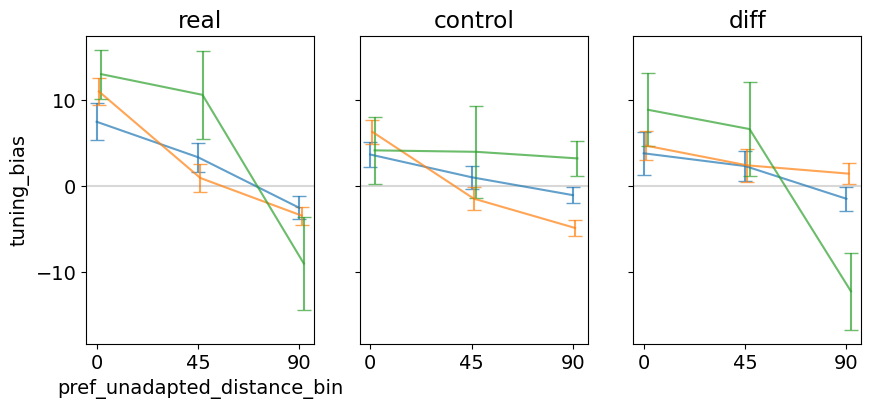

In [277]:
# set plt style to default
plt.style.use('default')

# set font size
plt.rcParams.update({'font.size': 14})

fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True, sharex=True)
jitter = 1
for i, iarea in enumerate(df_filter.area.unique()):
    axes[0].errorbar(x=np.array(sorted(df_filter[df_filter.area == iarea].pref_unadapted_distance_bin.unique())) + i * jitter,
                    y=df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias.mean(), 
                    yerr=df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias.sem(), 
                    capsize=5, alpha=.7)


    axes[1].errorbar(x=np.array(sorted(df_filter[df_filter.area == iarea].pref_unadapted_distance_bin.unique())) + i * jitter,
                    y=df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias_control.mean(),
                    yerr=df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias_control.sem(),
                    capsize=5, alpha=.7)
    
    axes[2].errorbar(x=np.array(sorted(df_filter[df_filter.area == iarea].pref_unadapted_distance_bin.unique())) + i * jitter,
                    y=df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias_diff.mean(),
                    yerr=df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias_diff.sem(),
                    capsize=5, alpha=.7)

axes[0].axhline(0, color='gray', linestyle='-', alpha=.3);
axes[1].axhline(0, color='gray', linestyle='-', alpha=.3);
axes[2].axhline(0, color='gray', linestyle='-', alpha=.3);

axes[0].set_title('real')
axes[0].set_xlabel('pref_unadapted_distance_bin')
axes[0].set_ylabel('tuning_bias')
axes[0].set_xticks([0, 45, 90])
axes[0].set_xticklabels([0, 45, 90])

axes[1].set_title('control');
axes[1].set_xticks([0, 45, 90])
axes[1].set_xticklabels([0, 45, 90])

axes[2].set_title('diff');
axes[2].set_xticks([0, 45, 90])
axes[2].set_xticklabels([0, 45, 90]);

fig.savefig(os.path.join(r'C:\Users\ll357\Documents\inter\results\tuning bias'.replace('\\', '/'), 'tuning_bias_by_area_with_control.pdf'), bbox_inches='tight')

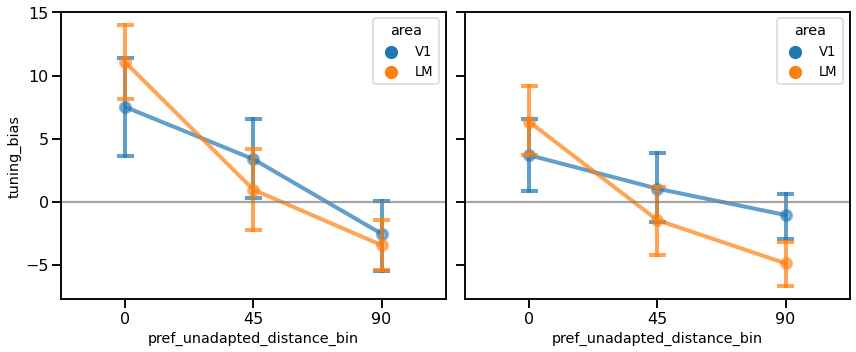

In [307]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
g1 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias', 
                   data=df_filter[df_filter.area != 'LI'], hue='area',
                   errorbar="se", errwidthfloat=1, capsize=.1,
                   ax=axes[0],
                   )
g2 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias_control', 
                   data=df_filter[df_filter.area != 'LI'], hue='area',
                   errorbar="se", errwidthfloat=1, capsize=.1,
                   ax=axes[1],
                  )
axes[0].axhline(0, color='gray', linestyle='-', alpha=.3);
axes[1].axhline(0, color='gray', linestyle='-', alpha=.3);

g2.set(ylabel=None) # remove ylabel
plt.setp(axes[0].collections, alpha=.5);
plt.setp(axes[1].collections, alpha=.5);
plt.setp(axes[0].lines, alpha=.7);
plt.setp(axes[1].lines, alpha=.7);
fig.tight_layout();

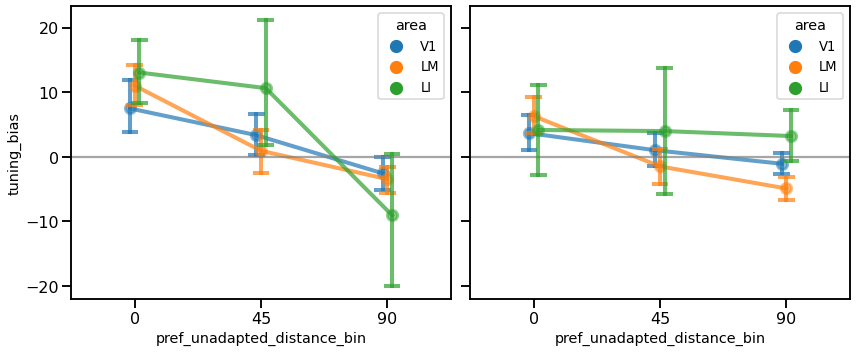

In [325]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
g1 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias', data=df_filter, hue='area',
                   errorbar="se", errwidthfloat=1, capsize=.1,
                   ax=axes[0], dodge=True,
                   )
g2 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias_control', data=df_filter, hue='area',
                  errorbar="se", errwidthfloat=1, capsize=.1,
                  ax=axes[1], dodge=True,
                  )
axes[0].axhline(0, color='gray', linestyle='-', alpha=.3);
axes[1].axhline(0, color='gray', linestyle='-', alpha=.3);

g2.set(ylabel=None) # remove ylabel
plt.setp(axes[0].collections, alpha=.5);
plt.setp(axes[1].collections, alpha=.5);
plt.setp(axes[0].lines, alpha=.7);
plt.setp(axes[1].lines, alpha=.7);
fig.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'tuning_bias_by_area.pdf'))

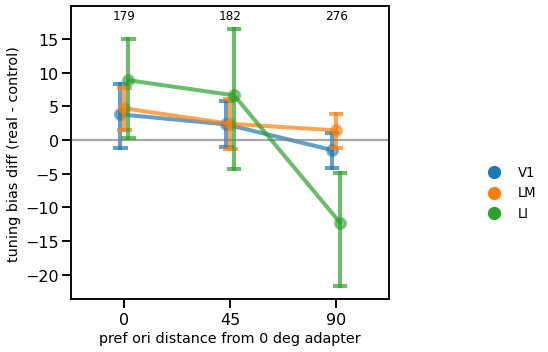

In [344]:
fig, axes = plt.subplots(1, 1, figsize=(9, 5), sharey=True)
g1 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias_diff', data=df_filter, hue='area',
                   errorbar='se', 
                #    errorbar=('ci', 68), 
                   errwidthfloat=1, capsize=.1,
                   ax=axes, dodge=True,
                   )

# annotation above each dot, ncell
ncell_bin = df_filter.groupby('pref_unadapted_distance_bin').cell_id.nunique().sort_index().values
ylim = axes.get_ylim()
axes.set_ylim(ylim[0], ylim[1] + 1.5)
for i in range(len(ncell_bin)):
    axes.annotate(str(ncell_bin[i]), (i, ylim[1] + 0.1), ha='center', va='center', size=12)

axes.legend(frameon=False, bbox_to_anchor=(1.5, 0.5))
g1.set(xlabel='pref ori distance from 0 deg adapter')
g1.set(ylabel='tuning bias diff (real - control)')
axes.axhline(0, color='gray', linestyle='-', alpha=.3);
plt.setp(axes.collections, alpha=.5);
plt.setp(axes.lines, alpha=.7);
fig.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'tuning_bias_control_diff_by_area.pdf'))

### stats sig

In [25]:
pref_unadapted_distance_bin = 90
data = np.array([
                df_filter[(df_filter.area == 'V1') & (df_filter.pref_unadapted_distance_bin == pref_unadapted_distance_bin)].tuning_bias_diff.values,
                df_filter[(df_filter.area == 'LM') & (df_filter.pref_unadapted_distance_bin == pref_unadapted_distance_bin)].tuning_bias_diff.values,
                df_filter[(df_filter.area == 'LI') & (df_filter.pref_unadapted_distance_bin == pref_unadapted_distance_bin)].tuning_bias_diff.values,
                ], dtype=object)
data.shape, data[0].shape, data[1].shape, data[2].shape

((3,), (84,), (175,), (17,))

In [26]:
## t test
from scipy.stats import ttest_ind

## assumption: equal variance
print(np.var(data[0]), np.var(data[1]),) # assumption not met

t, p = ttest_ind(data[0], data[1], equal_var=False, alternative='less') #, permutations=10000, random_state=0)
t, p

159.55193074673565 277.28870767509255


(-1.5635064143636679, 0.05972281688189927)

In [27]:
## one way ANOVA
from scipy.stats import f_oneway

## assumption: equal variance
print(np.var(data[0]), np.var(data[1]), np.var(data[2]))
## assumption: normality
from scipy.stats import shapiro
print(shapiro(data[0]).pvalue, shapiro(data[1]).pvalue, shapiro(data[2]).pvalue)

f_oneway(data[0], data[1], data[2])

159.55193074673565 277.28870767509255 322.2720352824679
8.062943201991857e-09 6.215306314061309e-08 0.0006468608044087887


F_onewayResult(statistic=6.259144877158457, pvalue=0.002198717293043121)

In [28]:
from scipy.stats import kruskal
kruskal(data[0], data[1], data[2])

KruskalResult(statistic=13.168785484999262, pvalue=0.0013817662007700436)

### ncell by area & well fit %

In [29]:
df_filter.groupby(['pref_unadapted_distance_bin', 'area']).cell_id.nunique(), \
df_tidy.groupby(['pref_unadapted_distance_bin', 'area']).cell_id.nunique(), 

(pref_unadapted_distance_bin  area
 0                            LI        5
                              LM      117
                              V1       57
 45                           LI       10
                              LM       87
                              V1       85
 90                           LI       17
                              LM      175
                              V1       84
 Name: cell_id, dtype: int64,
 pref_unadapted_distance_bin  area
 0                            LI      327
                              LM      739
                              V1      216
 45                           LI      238
                              LM      417
                              V1      176
 90                           LI      305
                              LM      559
                              V1      191
 Name: cell_id, dtype: int64)

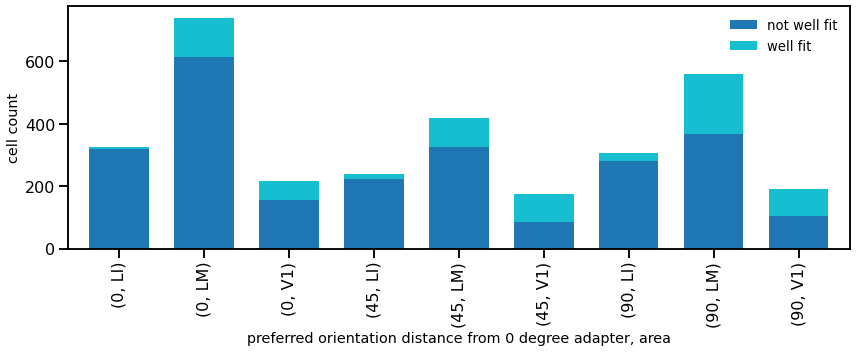

In [30]:
# stacked bar plot, colored by well_fit, for each area
df_tidy.groupby(['pref_unadapted_distance_bin', 'area', 'filter_cell_well_fit']).cell_id.nunique().unstack().plot(kind='bar', stacked=True, figsize=(12, 5), title='well_fit', colormap='tab10', legend='reverse', width=0.7);

# set legend frameon=False
plt.legend(frameon=False);

# set legend text content
plt.legend(['not well fit', 'well fit'], frameon=False);

plt.xlabel('preferred orientation distance from 0 degree adapter, area')
plt.ylabel('cell count')
plt.title('');
plt.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'well_fit_by_area.pdf'))

# df for tuning curve

In [256]:
df_tuning = df_tidy[['dfof', 'cell_id', 'resp_id', 'isi', 'stim2_id', 
                    'area', 'filter_cell_vis', 'filter_cell_well_fit', 'filter_cell_well_fit_ad_250', 
                    'ori_pref_ad_250', 'ori_pref_noad', 
                    'pref_unadapted_distance', 'pref_unadapted_distance_bin', 'pref_adapted_distance', 
                    'tuning_bias', 'tuning_bias_control',]]
df_tuning = df_tuning[(df_tuning.isi > -1) # placeholder, always true
                    # & (df_tuning.area == 'LI')
                    & (df_tuning.filter_cell_vis == True)
                    & (df_tuning.filter_cell_well_fit == True)
                    # & (df_tuning.filter_cell_well_fit_ad_250 == True) # only use cells that are well fit in both conditions: noad and ad 250
                    & ((df_tuning.isi == 250) | (df_tuning.isi == 6000))
                    # & (df_tuning.pref_unadapted_distance_bin == 90)
                    ]
                    
df_tuning['tuning_noad'] = np.pi
df_tuning['tuning_250'] = np.pi

for icell in tqdm(df_tuning.cell_id.unique()):
    ## tuning curve when isi = 6000, no adapter
    tuning_noad = df_tuning.loc[(df_tuning.cell_id == icell) & (df_tuning.isi == 6000) & (df_tuning.resp_id == 'R2'), :].groupby(['stim2_id'], sort=True).agg(np.nanmean)['dfof'].values# groupby sort: sorted by key, aka stim2_id. take R2 of no adapter trials to get tuning curve when no adapter
    df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_noad'] = df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_noad'].apply(lambda x: tuning_noad)
    
    ## tuning curve when isi = 250
    tuning_250 = df_tuning.loc[(df_tuning.cell_id == icell) & (df_tuning.isi == 250) & (df_tuning.resp_id == 'R2'), :].groupby(['stim2_id'], sort=True).agg(np.nanmean)['dfof'].values
    df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_250'] = df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_250'].apply(lambda x: tuning_250)

df_tuning.sort_values(by=['tuning_bias'], inplace=True) # df_tuning sort by tuning_bias_distance
df_tuning.sample(5, random_state=0) # NOTE: where isi=6000, pref_adapted_distance and tuning_bias are NaN

100%|██████████| 637/637 [01:18<00:00,  8.17it/s]


,dfof,cell_id,resp_id,isi,stim2_id,area,filter_cell_vis,filter_cell_well_fit,filter_cell_well_fit_ad_250,ori_pref_ad_250,ori_pref_noad,pref_unadapted_distance,pref_unadapted_distance_bin,pref_adapted_distance,tuning_bias,tuning_bias_control,tuning_noad,tuning_250
1431864,0.091252,230302_003_24,R2,6000,1,LM,True,1.0,False,69.983701,70.271948,70.271948,90,NaN,NaN,6.696912,"[0.0631046946658928, 0.08631644337187894, 0.11...","[0.01766566223294723, 0.05058328542472208, 0.0..."
914327,0.006230,210127_003_58,R1,250,4,LM,True,1.0,True,79.045107,75.647372,75.647372,90,79.045107,3.397735,1.253124,"[-0.011927335997344225, 0.042780367838578776, ...","[-0.027590681072318206, 0.015574299632528403, ..."
938236,-0.014828,210127_003_49,R2,250,5,LM,True,1.0,True,68.573857,51.376516,51.376516,45,68.573857,17.197341,14.073588,"[0.050867797957229954, 0.05171386894375795, 0....","[0.02882323940351859, 0.11224010873484588, 0.3..."
126699,0.053651,200728_003_34,R2,6000,7,V1,True,1.0,False,144.928572,154.980702,25.019298,0,NaN,NaN,4.558280,"[0.09792940420334809, 0.07179385315936487, 0.0...","[0.046342642949035666, 0.0588971591117751, 0.0..."
2198641,0.192849,230228_002_3,R2,6000,3,LI,True,1.0,True,50.747368,41.819138,41.819138,45,NaN,NaN,-10.224169,"[0.026358741969781864, 0.18673845669393735, 0....","[-0.00743369028408612, 0.14129635403344462, 0...."


## polar plot of tuning
before and after adaptation  
filter cells 

In [258]:
df_tuning = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False)
df_tuning.groupby('cell_id', sort=False)['area', 'gOSI_noad', 'gOSI_250'].first()#.head(20)

In [ ]:
for icell in tqdm(df_tuning.cell_id.unique()):

    gOSI_noad = df_tuning[df_tuning.cell_id == icell].gOSI_noad.values[0]
    gOSI_250 = df_tuning[df_tuning.cell_id == icell].gOSI_250.values[0]

    tuning_noad = df_tuning[df_tuning.cell_id == icell].tuning_noad.values[0]
    tuning_noad = np.append(tuning_noad, tuning_noad) # repeat 8 values twice to make 16 values for polar plot
    tuning_noad = np.append(tuning_noad, tuning_noad[0]) # repeat first value at the end to close the circle
    ori_pref_noad = df_tuning[df_tuning.cell_id == icell].ori_pref_noad.values[0]
    # print('ori_pref_noad deg: ', np.round(ori_pref_noad, 2))
    ori_pref_noad = ori_pref_noad * np.pi / 180 # degree to radian

    tuning_250 = df_tuning[df_tuning.cell_id == icell].tuning_250.values[0]
    tuning_250 = np.append(tuning_250, tuning_250)
    tuning_250 = np.append(tuning_250, tuning_250[0])
    ori_pref_ad_250 = df_tuning[df_tuning.cell_id == icell].ori_pref_ad_250.values[0]
    # print('ori_pref_ad_250 deg: ', np.round(ori_pref_ad_250, 2))
    ori_pref_ad_250 = ori_pref_ad_250 * np.pi / 180

    tuning_bias = df_tuning[df_tuning.cell_id == icell].tuning_bias.values[0]
    # print('no adapter: ', np.round(tuning_noad, 2))
    # print('250 ms: ', np.round(tuning_250, 2))
    # print('tuning_bias: ', np.round(tuning_bias, 2))

    fig, ax = plt.subplots(1, 1, figsize=(12, 12), subplot_kw=dict(projection='polar'))
    ax.plot(np.linspace(0, 2*np.pi, 17), tuning_noad, alpha=.5, linewidth=10)
    ax.plot(np.linspace(0, 2*np.pi, 17), tuning_250, alpha=.5, linewidth=10)

    # plot adapter ori as a line
    min_val = np.min([np.min(tuning_noad), np.min(tuning_250)])
    max_val = np.max([np.max(tuning_noad), np.max(tuning_250)])
    # ax.plot([0, np.pi], [max_val, max_val], color='gray', linewidth=5, alpha=.5, label='adapter ori')

    # ## plot 90 deg as a line
    # ax.plot([np.pi/2, np.pi/2], [min_val, max_val], color='cyan', linewidth=5, alpha=.5, linestyle='-')
    # ax.plot([np.pi*3/2, np.pi*3/2], [min_val, max_val], color='cyan', linewidth=5, alpha=.5, linestyle='-')

    ## plot pref ori (noad) as a line
    ax.plot([ori_pref_noad, ori_pref_noad], [min_val, max_val], color='blue', linewidth=5, alpha=.5, label='pref ori no adapter')
    ori_pref_noad_opp = ori_pref_noad + np.pi # find opposite orientation of pref ori
    if ori_pref_noad_opp > 2*np.pi:
        ori_pref_noad_opp = ori_pref_noad_opp - 2*np.pi
    ax.plot([ori_pref_noad_opp, ori_pref_noad_opp], [min_val, max_val], color='blue', linewidth=5, alpha=.5, linestyle='-')

    ## plot pref ori (ad 250) as a line
    ax.plot([ori_pref_ad_250, ori_pref_ad_250], [min_val, max_val], color='orange', linewidth=5, alpha=.5, label='pref ori isi=250')
    ori_pref_ad_250_opp = ori_pref_ad_250 + np.pi
    if ori_pref_ad_250_opp > 2*np.pi:
        ori_pref_ad_250_opp = ori_pref_ad_250_opp - 2*np.pi
    ax.plot([ori_pref_ad_250_opp, ori_pref_ad_250_opp], [min_val, max_val], color='orange', linewidth=5, alpha=.5, linestyle='-')

    ## add text at top left
    bias_color = 'blue'
    minus_flag = 'pos'
    if tuning_bias < 0: # attractive bias
        bias_color = 'red'
        minus_flag = 'neg'
    plt.text(0.05, 0.9, f'tuning_bias: {np.round(tuning_bias, 2)}', transform=plt.gcf().transFigure, color=bias_color, fontsize=16) # in cartesian coordinates
    gOSI_color = 'green'
    if gOSI_noad < 0.5 or gOSI_250 < 0.5:
        gOSI_color = 'orange'
    if gOSI_noad < 0.5 and gOSI_250 < 0.5:
        gOSI_color = 'red'
    plt.text(0.05, 0.85, f'gOSI_noad: {np.round(gOSI_noad, 2)}', transform=plt.gcf().transFigure, color=gOSI_color, fontsize=16) # in cartesian coordinates
    plt.text(0.05, 0.8, f'gOSI_250: {np.round(gOSI_250, 2)}', transform=plt.gcf().transFigure, color=gOSI_color, fontsize=16) # in cartesian coordinates

    rticks = np.arange(0, max_val, step=0.05)
    ax.set_rticks(rticks)  # fewer radial ticks

    ax.set_xticks(np.linspace(0, 2*np.pi, 17))
    ax.set_xticklabels(np.arange(0, 360+22.5, 22.5))
    xticklabels = [label.get_text() for label in ax.get_xticklabels()]
    xticklabels[-1] = '' # set final xticklabel invisible
    ax.set_xticklabels(xticklabels)
    ax.set_ylim(min_val, max_val)

    area = df_tuning[df_tuning.cell_id == icell].area.values[0]
    ax.set_title(f'cell_id {icell} in {area}')
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.legend(bbox_to_anchor=(1.1, 1.1), frameon=False); # set legend position out of the way

    # break

    # save figure
    dir_result = r'C:\Users\ll357\Documents\inter\results\tuning bias single cell'.replace('\\', '/')
    fig.savefig(os.path.join(dir_result, 'gOSI', f'gOSI_{np.round(gOSI_noad, 2)}_{icell}_tuning_curve.png'), bbox_inches='tight', dpi=300)
    plt.close(fig)
    clear_output(wait=True)

100%|██████████| 637/637 [13:34<00:00,  1.28s/it]


## filter cell gOSI
for well fit cells, calculate global orientation selectivity index (gOSI)  
formula taken from [Causal importance of orientation selectivity for generalization in image recognition](https://openreview.net/pdf?id=Bkx_Dj09tQ)

In [259]:
for icell in tqdm(df_tuning.cell_id.unique()):
    df_cell = df_tuning[df_tuning.cell_id == icell]

    tuning_noad = df_cell.tuning_noad.values[0] - min(df_cell.tuning_noad.values[0]) # ensure all values are non negative
    tuning_250 = df_cell.tuning_250.values[0] - min(df_cell.tuning_250.values[0])

    theta_arr = np.linspace(0, 180-22.5, 8) # according to formula: unit deg, not rad
    sin_arr = np.sin(2 * theta_arr)
    cos_arr = np.cos(2 * theta_arr)

    gOSI_noad = np.sqrt((np.sum(tuning_noad * sin_arr))**2 + (np.sum(tuning_noad * cos_arr))**2) / np.sum(tuning_noad)
    gOSI_250 = np.sqrt((np.sum(tuning_250 * sin_arr))**2 + (np.sum(tuning_250 * cos_arr))**2) / np.sum(tuning_250)

    df_tuning.loc[df_tuning.cell_id == icell, 'gOSI_noad'] = gOSI_noad
    df_tuning.loc[df_tuning.cell_id == icell, 'gOSI_250'] = gOSI_250

df_tuning

100%|██████████| 637/637 [00:28<00:00, 22.20it/s]


,dfof,cell_id,resp_id,isi,stim2_id,area,filter_cell_vis,filter_cell_well_fit,filter_cell_well_fit_ad_250,ori_pref_ad_250,ori_pref_noad,pref_unadapted_distance,pref_unadapted_distance_bin,pref_adapted_distance,tuning_bias,tuning_bias_control,tuning_noad,tuning_250,gOSI_noad,gOSI_250
2322794,-0.042163,230309_002_44,R1,250,4,LI,True,1.0,True,157.950710,87.108328,87.108328,90,22.04929,-65.059039,2.891672,"[0.00783789118802318, -0.010416012819600093, -...","[-0.0038399850967165004, -0.0167066432906987, ...",0.529524,0.581159
2362336,0.013265,230309_002_44,R2,250,7,LI,True,1.0,True,157.950710,87.108328,87.108328,90,22.04929,-65.059039,2.891672,"[0.00783789118802318, -0.010416012819600093, -...","[-0.0038399850967165004, -0.0167066432906987, ...",0.529524,0.581159
2362339,0.001395,230309_002_44,R2,250,5,LI,True,1.0,True,157.950710,87.108328,87.108328,90,22.04929,-65.059039,2.891672,"[0.00783789118802318, -0.010416012819600093, -...","[-0.0038399850967165004, -0.0167066432906987, ...",0.529524,0.581159
2362340,-0.020520,230309_002_44,R2,250,0,LI,True,1.0,True,157.950710,87.108328,87.108328,90,22.04929,-65.059039,2.891672,"[0.00783789118802318, -0.010416012819600093, -...","[-0.0038399850967165004, -0.0167066432906987, ...",0.529524,0.581159
2362342,0.039252,230309_002_44,R2,250,0,LI,True,1.0,True,157.950710,87.108328,87.108328,90,22.04929,-65.059039,2.891672,"[0.00783789118802318, -0.010416012819600093, -...","[-0.0038399850967165004, -0.0167066432906987, ...",0.529524,0.581159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2479010,0.008897,230323_002_49,R2,6000,4,LI,True,1.0,False,22.881534,4.313019,4.313019,0,NaN,NaN,11.935104,"[0.16299589613439838, 0.11930714247099108, -0....","[-0.011303308363845905, 0.03746266701758842, 0...",0.670210,0.246599
2479016,-0.064279,230323_002_49,R2,6000,4,LI,True,1.0,False,22.881534,4.313019,4.313019,0,NaN,NaN,11.935104,"[0.16299589613439838, 0.11930714247099108, -0....","[-0.011303308363845905, 0.03746266701758842, 0...",0.670210,0.246599
2479017,-0.121125,230323_002_49,R2,6000,3,LI,True,1.0,False,22.881534,4.313019,4.313019,0,NaN,NaN,11.935104,"[0.16299589613439838, 0.11930714247099108, -0....","[-0.011303308363845905, 0.03746266701758842, 0...",0.670210,0.246599
2479018,0.004345,230323_002_49,R2,6000,5,LI,True,1.0,False,22.881534,4.313019,4.313019,0,NaN,NaN,11.935104,"[0.16299589613439838, 0.11930714247099108, -0....","[-0.011303308363845905, 0.03746266701758842, 0...",0.670210,0.246599


In [260]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
df_tuning.sort_values(by='area', ascending=False).groupby(['area', 'cell_id'], sort=False).gOSI_noad.hist(bins=20, alpha=.5, ax=axes[0]);
df_tuning.sort_values(by='area', ascending=False).groupby(['area', 'cell_id'], sort=False).gOSI_250.hist(bins=20, alpha=.5, ax=axes[1]);

axes[0].legend(['V1', 'LM', 'LI',], frameon=False) # sorted area descending
plt.tight_layout();
## indeed, gOSI is between 0 and 1. higher gOSI means more orientation selective

Error in callback <function flush_figures at 0x000002345934DB80> (for post_execute):


KeyboardInterrupt: 

In [261]:
df_tuning.groupby('area').gOSI_noad.describe() # df tuning is well-fit cells only. even so, LI gOSI is much worse than V1 and LM

,count,mean,std,min,25%,50%,75%,max
area,,,,,,,,
LI,15602.0,0.499377,0.108760,0.289015,0.425343,0.492173,0.563361,0.709965
LM,186036.0,0.547436,0.148353,0.114256,0.444634,0.553049,0.661415,0.845744
V1,104642.0,0.547458,0.155385,0.139127,0.426200,0.559070,0.654359,0.866154


In [262]:
df_tidy.groupby('area').filter_cell_well_fit.describe() # well fit cell filter discards most cells in LI already

,count,mean,std,min,25%,50%,75%,max
area,,,,,,,,
LI,713872.0,0.055403,0.228766,0.0,0.0,0.0,0.0,1.0
LM,1393600.0,0.238967,0.426453,0.0,0.0,0.0,0.0,1.0
V1,459063.0,0.408351,0.491529,0.0,0.0,0.0,1.0,1.0


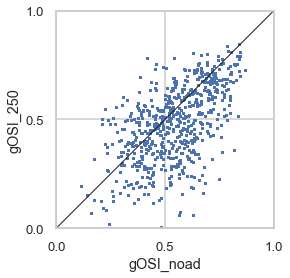

In [263]:
tmp1 = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False).gOSI_noad.values
tmp2 = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False).gOSI_250.values
tmp3 = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False).tuning_bias.values

plt.scatter(tmp1, tmp2, alpha=.1, s=1);
plt.plot([0, 1], [0, 1], color='k', linestyle='-', linewidth=1); # draw diagonal line

plt.xlim([0, 1]);
plt.ylim([0, 1]);
plt.xticks([0, .5, 1]);
plt.yticks([0, .5, 1]);
plt.xlabel('gOSI_noad');
plt.ylabel('gOSI_250');
plt.gca().set_aspect('equal', adjustable='box'); # set axis square

## gOSI noad is usually higher. gOSI noad vs 250 is correlated

r2 score of gOSI_noad vs tuning_bias:  0.01999189972339943
r2 score of gOSI_250 vs tuning_bias:  0.0034475291680431397
slope:  15.293958524937405
intercept:  -6.300087231468615
positive correlation between gOSI and tuning_bias


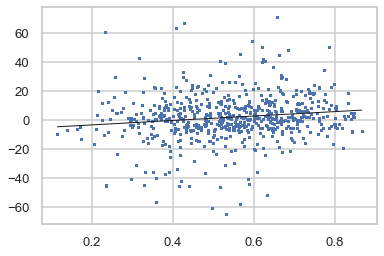

In [264]:
## regression: gOSI vs tuning_bias
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

tmp1 = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False).gOSI_noad.values
tmp2 = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False).gOSI_250.values
tmp3 = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False).tuning_bias.values
tmp1 = tmp1[~np.isnan(tmp3)]
tmp2 = tmp2[~np.isnan(tmp3)]
tmp3 = tmp3[~np.isnan(tmp3)]
tmp1 = tmp1.reshape(-1, 1)
tmp2 = tmp2.reshape(-1, 1)
tmp3 = tmp3.reshape(-1, 1)

reg1 = LinearRegression().fit(tmp1, tmp3)
reg2 = LinearRegression().fit(tmp2, tmp3)
print('r2 score of gOSI_noad vs tuning_bias: ', r2_score(tmp3, reg1.predict(tmp1)))
print('r2 score of gOSI_250 vs tuning_bias: ', r2_score(tmp3, reg2.predict(tmp2)))

plt.scatter(tmp1, tmp3, alpha=.1, s=1);
plt.plot(tmp1, reg1.predict(tmp1), color='k', linestyle='-', linewidth=1);
print('slope: ', reg1.coef_[0][0])
print('intercept: ', reg1.intercept_[0])

print('positive correlation between gOSI and tuning_bias')

### tuning bias plot - high gOSI
didnt seem to help

In [265]:
gOSI_thres = 0.5 # In visual neuroscience, neurons with gOSI > 0.33 are often considered to be orientation-selective (Piscopo et al., 2013; Kondo & Ohki, 2015).
df_tuning_gOSI = df_tuning[(df_tuning.gOSI_noad > gOSI_thres) & (df_tuning.gOSI_250 > gOSI_thres)]
print(df_tuning_gOSI.groupby('area').cell_id.nunique())

df_tuning_gOSI = df_tuning_gOSI.groupby('cell_id')[['area', 'pref_unadapted_distance_bin', 'tuning_bias', 'tuning_bias_control']].first().reset_index()
df_tuning_gOSI

area
LI     10
LM    152
V1     94
Name: cell_id, dtype: int64


,cell_id,area,pref_unadapted_distance_bin,tuning_bias,tuning_bias_control
0,200720_003_24,V1,0,11.165754,-4.270538
1,200720_003_29,V1,0,4.465665,6.922370
2,200720_003_57,V1,0,13.236476,0.945789
3,200720_003_59,V1,45,54.626962,7.780432
4,200720_003_61,V1,45,-0.369852,-10.973383
...,...,...,...,...,...
251,230307_004_24,LM,0,28.209884,6.004743
252,230307_004_26,LM,0,-12.258905,3.118108
253,230307_004_45,LM,90,-40.721540,-13.967277
254,230307_004_47,LM,0,7.807087,3.307979


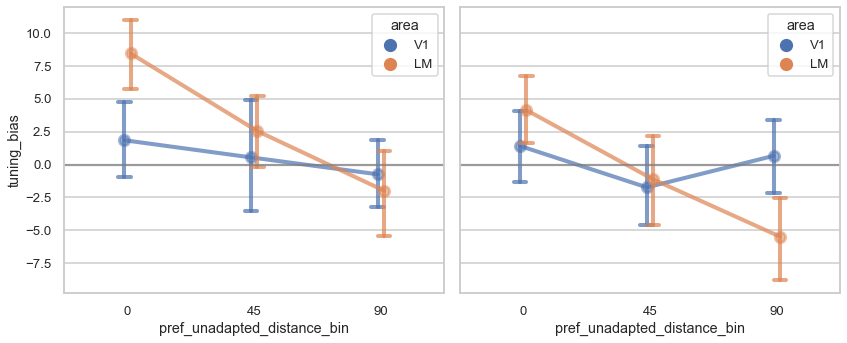

In [266]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
g1 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias', 
                   data=df_tuning_gOSI[df_tuning_gOSI.area != 'LI'], hue='area',
                   errorbar='sd', # ('ci', 68), 
                   errwidthfloat=1, capsize=.1,
                   ax=axes[0], dodge=True,
                   )
g2 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias_control', 
                   data=df_tuning_gOSI[df_tuning_gOSI.area != 'LI'], hue='area',
                  errorbar=('ci', 68), errwidthfloat=1, capsize=.1,
                  ax=axes[1], dodge=True, legend=False,
                  )
axes[0].axhline(0, color='gray', linestyle='-', alpha=.3);
axes[1].axhline(0, color='gray', linestyle='-', alpha=.3);

g2.set(ylabel=None) # remove ylabel
plt.setp(axes[0].collections, alpha=.5);
plt.setp(axes[1].collections, alpha=.5);
plt.setp(axes[0].lines, alpha=.7);
plt.setp(axes[1].lines, alpha=.7);
fig.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'tuning_bias_by_area.pdf'))

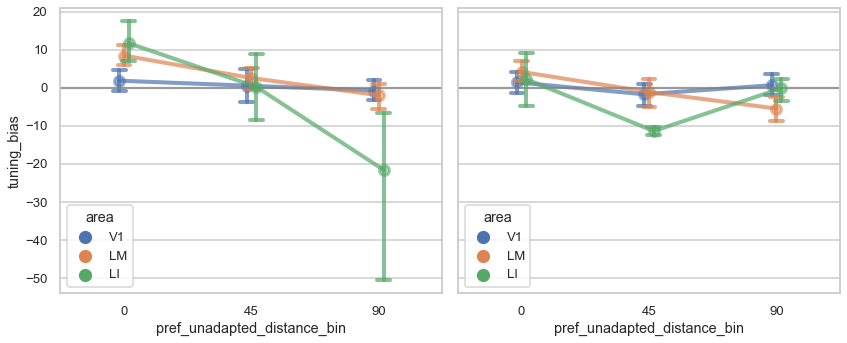

In [267]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
g1 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias', data=df_tuning_gOSI, hue='area',
                   errorbar='sd', # ('ci', 68), 
                   errwidthfloat=1, capsize=.1,
                   ax=axes[0], dodge=True,
                   )
g2 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias_control', data=df_tuning_gOSI, hue='area',
                  errorbar=('ci', 68), errwidthfloat=1, capsize=.1,
                  ax=axes[1], dodge=True, legend=False,
                  )
axes[0].axhline(0, color='gray', linestyle='-', alpha=.3);
axes[1].axhline(0, color='gray', linestyle='-', alpha=.3);

g2.set(ylabel=None) # remove ylabel
plt.setp(axes[0].collections, alpha=.5);
plt.setp(axes[1].collections, alpha=.5);
plt.setp(axes[0].lines, alpha=.7);
plt.setp(axes[1].lines, alpha=.7);
fig.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'tuning_bias_by_area.pdf'))

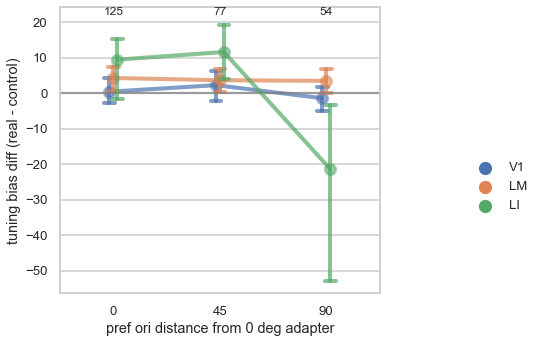

In [268]:
df_tuning_gOSI['tuning_bias_diff'] = df_tuning_gOSI['tuning_bias'] - df_tuning_gOSI['tuning_bias_control']

fig, axes = plt.subplots(1, 1, figsize=(9, 5), sharey=True)
g1 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias_diff', data=df_tuning_gOSI, hue='area',
                   errorbar=('ci', 68), errwidthfloat=1, capsize=.1,
                   ax=axes, dodge=True,
                   )

# annotation above each dot, ncell
ncell_bin = df_tuning_gOSI.groupby('pref_unadapted_distance_bin').cell_id.nunique().sort_index().values
ylim = axes.get_ylim()
axes.set_ylim(ylim[0], ylim[1] + 1.5)
for i in range(len(ncell_bin)):
    axes.annotate(str(ncell_bin[i]), (i, ylim[1] + 0.1), ha='center', va='center', size=12)

axes.legend(frameon=False, bbox_to_anchor=(1.5, 0.5))
g1.set(xlabel='pref ori distance from 0 deg adapter')
g1.set(ylabel='tuning bias diff (real - control)')
axes.axhline(0, color='gray', linestyle='-', alpha=.3);
plt.setp(axes.collections, alpha=.5);
plt.setp(axes.lines, alpha=.7);
fig.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'tuning_bias_control_diff_by_area.pdf'))

## filter cell ori-mod
dont fit tuning curve, dont filter well fit cells.  
find orientation-modulated cells by anova across all orientations responses

In [245]:
df_tidy#.columns

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,...,filter_cell_well_fit_ad_250,filter_cell_well_fit_ad_750,mouse,date,sess,pref_unadapted_distance,pref_unadapted_distance_bin,pref_adapted_distance,tuning_bias,tuning_bias_control
0,-0.003253,200720_003_0,0,R1,750,1,5,V1,0,True,...,True,True,1323,200720,3,73.675005,90,71.987028,-1.687976,2.857408
1,0.088726,200720_003_0,1,R1,250,1,2,V1,0,True,...,True,True,1323,200720,3,73.675005,90,71.465895,-2.209110,2.857408
2,-0.010485,200720_003_0,2,R1,250,1,2,V1,0,True,...,True,True,1323,200720,3,73.675005,90,71.465895,-2.209110,2.857408
3,-0.050493,200720_003_0,3,R1,750,1,3,V1,0,True,...,True,True,1323,200720,3,73.675005,90,71.987028,-1.687976,2.857408
4,0.052611,200720_003_0,5,R1,750,1,0,V1,0,True,...,True,True,1323,200720,3,73.675005,90,71.987028,-1.687976,2.857408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2566530,0.056616,230323_003_64,496,R2,6000,0,5,LI,0,False,...,False,False,1374,230323,3,15.044770,0,NaN,NaN,52.021868
2566531,0.077247,230323_003_64,497,R2,6000,0,6,LI,0,False,...,False,False,1374,230323,3,15.044770,0,NaN,NaN,52.021868
2566532,0.026982,230323_003_64,498,R2,250,1,6,LI,0,False,...,False,False,1374,230323,3,15.044770,0,68.311464,53.266694,52.021868
2566533,-0.069060,230323_003_64,499,R2,6000,0,7,LI,0,False,...,False,False,1374,230323,3,15.044770,0,NaN,NaN,52.021868


In [246]:
cell_property

,cell_id,isi,area,filter_cell_vis
0,200720_003_0,250,V1,True
1,200720_003_0,750,V1,True
2,200720_003_0,6000,V1,True
3,200720_003_1,250,V1,False
4,200720_003_1,750,V1,False
...,...,...,...,...
9499,230323_003_8,750,LI,False
9500,230323_003_8,6000,LI,False
9501,230323_003_9,250,LI,False
9502,230323_003_9,750,LI,False


In [215]:
## construct tuning_vec column

cell_property = (df_tidy[['cell_id', 'isi', 'area', 'filter_cell_vis']] # need cell info: area, vis driven
                 .groupby(['cell_id', 'isi']) # prepare to match with df_ori_mod
                 .first() # only take first value. all values should be the same for each cell and isi combination
                 .reset_index())

df_ori_mod = (df_tidy[df_tidy.resp_id == 'R2'] # only R2 has diff ori
            [['dfof', 'cell_id', 'resp_id', 'isi', 'stim2_id']]
              .groupby(['cell_id', 'isi', 'stim2_id']).agg({'dfof': 'mean'}) # aggregate resp by cell, isi, ori
              .groupby(['cell_id', 'isi']).agg({'dfof':lambda x: list(x)}) # each row is a list of aggregated resp across ori
              .reset_index()
              .rename(columns={'dfof': 'tuning_vec'})
              .merge(cell_property, on=['cell_id', 'isi'], how='left') # merge with cell info
            )
df_ori_mod

,cell_id,isi,tuning_vec,area,filter_cell_vis
0,200720_003_0,250,"[0.016361998006661493, 0.010278129175002568, 0...",V1,True
1,200720_003_0,750,"[0.025038532340778488, 0.027538047461942633, 0...",V1,True
2,200720_003_0,6000,"[0.020152732636819985, -0.0013945580654881541,...",V1,True
3,200720_003_1,250,"[0.036562610558938564, 0.057022308981587506, 0...",V1,False
4,200720_003_1,750,"[0.050733120887446, 0.03534524443593661, 0.035...",V1,False
...,...,...,...,...,...
9499,230323_003_8,750,"[-0.0020103057934456998, 0.02516011264431533, ...",LI,False
9500,230323_003_8,6000,"[-0.012925911906040232, 0.044753586599356916, ...",LI,False
9501,230323_003_9,250,"[0.0030077152815922614, -0.0125080357181489, 0...",LI,False
9502,230323_003_9,750,"[-0.041036061351614035, -0.015300348556458088,...",LI,False


In [216]:
## construct ori_mod column

from scipy.stats import kruskal
p_threshold = 0.05

df_kruskal = (df_tidy[df_tidy.resp_id == 'R2'] # only R2 has diff ori
            [['dfof', 'cell_id', 'isi', 'stim2_id']]
            .groupby(['cell_id', 'isi', 'stim2_id']) # for each cell, each isi condition, calc responses to each ori
            .agg({'dfof':lambda x: list(x)}) # each row, dfof col contains a list of ori responses across trials
            .reset_index()
            .groupby(['cell_id', 'isi']) # for each cell, each isi condition, calc ori modulation
            .apply(lambda x: kruskal(*x.dfof.values).pvalue < p_threshold) # kruskal, where each ori is a group
            .reset_index()
            )
df_kruskal = df_kruskal.rename(columns={0: 'ori_mod'}) # bool col for ori modulation

df_ori_mod = df_ori_mod.merge(df_kruskal, on=['cell_id', 'isi'], how='left')
df_ori_mod

,cell_id,isi,tuning_vec,area,filter_cell_vis,ori_mod
0,200720_003_0,250,"[0.016361998006661493, 0.010278129175002568, 0...",V1,True,False
1,200720_003_0,750,"[0.025038532340778488, 0.027538047461942633, 0...",V1,True,True
2,200720_003_0,6000,"[0.020152732636819985, -0.0013945580654881541,...",V1,True,True
3,200720_003_1,250,"[0.036562610558938564, 0.057022308981587506, 0...",V1,False,False
4,200720_003_1,750,"[0.050733120887446, 0.03534524443593661, 0.035...",V1,False,False
...,...,...,...,...,...,...
9499,230323_003_8,750,"[-0.0020103057934456998, 0.02516011264431533, ...",LI,False,False
9500,230323_003_8,6000,"[-0.012925911906040232, 0.044753586599356916, ...",LI,False,False
9501,230323_003_9,250,"[0.0030077152815922614, -0.0125080357181489, 0...",LI,False,False
9502,230323_003_9,750,"[-0.041036061351614035, -0.015300348556458088,...",LI,False,False


In [249]:
## construct max_ori and max_ori_distance column

df_ori_mod['max_ori'] = df_ori_mod.tuning_vec.apply(lambda x: np.argmax(x)) # NOTE: even though we calculated max_ori for isi 250 and 750, only isi 6000 was actually used below (inherited by df_lineplot)
df_ori_mod['max_ori_dist'] = df_ori_mod.max_ori.apply(lambda x: 22.5*(8-x) if x > 4 else 22.5*x) # distance from 0 deg, hard coded for 8 ori. TODO: modify if needed

# df_ori_mod.groupby('max_ori').max_ori_distance.value_counts()
# df_ori_mod.groupby('max_ori_distance').max_ori.value_counts()
df_ori_mod.groupby('max_ori').max_ori_dist.unique()

max_ori
0     [0.0]
1    [22.5]
2    [45.0]
3    [67.5]
4    [90.0]
5    [67.5]
6    [45.0]
7    [22.5]
Name: max_ori_dist, dtype: object

In [250]:
## prepare for lineplot. don't need tuning vec, but need (stim2_id, dfof) observations
df_lineplot = (df_tidy[df_tidy.resp_id == 'R2'] # only R2 has diff ori
                      [['dfof', 'cell_id', 
                        'area', 'filter_cell_vis',
                        'resp_id', 'isi', 'stim2_id']]
                        .reset_index(drop=True)
                        )

## inherit ori_mod, max_ori, max_ori_distance from df_ori_mod
df_lineplot = df_lineplot.merge(
      df_ori_mod[df_ori_mod.isi == 6000]
      [['cell_id', 'ori_mod', 'max_ori', 'max_ori_dist']], 
      on=['cell_id'], how='left') # only use isi 6000 (no adapter condition) to determine ori_mod, max_ori and max_ori_dist for each cell

df_lineplot

,dfof,cell_id,area,filter_cell_vis,resp_id,isi,stim2_id,ori_mod,max_ori,max_ori_dist
0,0.000877,200720_003_0,V1,True,R2,750,5,True,4,90.0
1,-0.055881,200720_003_0,V1,True,R2,250,2,True,4,90.0
2,0.037413,200720_003_0,V1,True,R2,250,2,True,4,90.0
3,0.512942,200720_003_0,V1,True,R2,750,3,True,4,90.0
4,0.046603,200720_003_0,V1,True,R2,6000,2,True,4,90.0
...,...,...,...,...,...,...,...,...,...,...
1509825,0.056616,230323_003_64,LI,False,R2,6000,5,False,0,0.0
1509826,0.077247,230323_003_64,LI,False,R2,6000,6,False,0,0.0
1509827,0.026982,230323_003_64,LI,False,R2,250,6,False,0,0.0
1509828,-0.069060,230323_003_64,LI,False,R2,6000,7,False,0,0.0


In [241]:
# stim2_id_dict = {0: 0,
#                  1: 1,
#                  2: 2,
#                  3: 3,
#                  4: 4,
#                  5: 3,
#                  6: 2,
#                  7: 1,}

# df_lineplot['stim2_id'] = df_lineplot.stim2_id.map(stim2_id_dict) # map stim2_id to ori
# df_lineplot

## tuning curve bias
no fitting, just align max response ori

In [326]:
df_lineplot['date'] = df_lineplot.cell_id.apply(lambda x: x.split('_')[0])
df_lineplot['sess'] = df_lineplot.cell_id.apply(lambda x: x.split('_')[1])
df_lineplot[df_lineplot.area == 'V1'].date.unique()

array(['200720', '200728', '200803', '201015', '201209', '210120'],
      dtype=object)

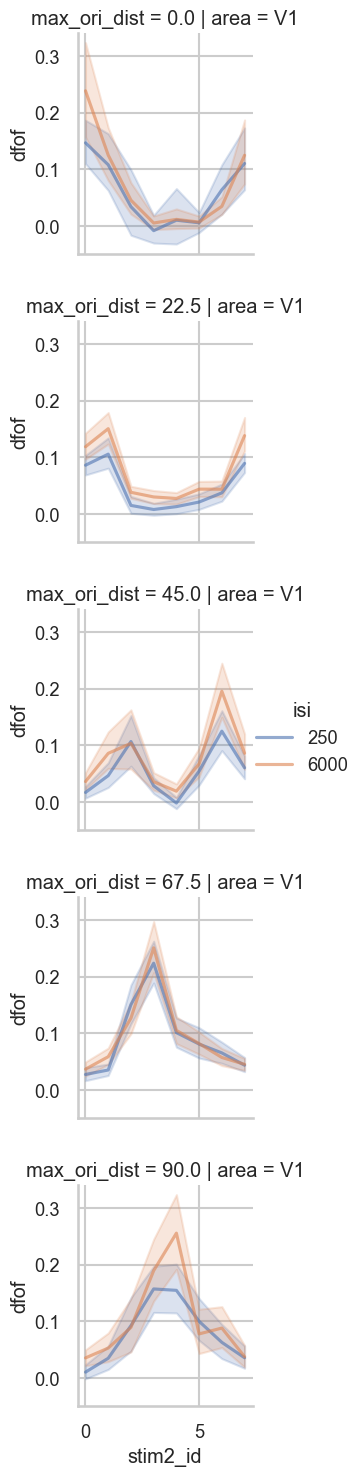

In [334]:
df_filter = df_lineplot[(df_lineplot.filter_cell_vis == True)
                       & (df_lineplot.ori_mod == True)
                       & (df_lineplot.isi != 750)
                     #   & (df_lineplot.date == '201015') # temporary filter to date, to match matlab san check for TC
                       & (df_lineplot.date == '210120') # temporary filter to date, to match matlab san check for TC
                       ]

sns.set(font_scale=0.8, context='talk', style='whitegrid')
g = sns.FacetGrid(df_filter, col="area", row="max_ori_dist", hue="isi")
g.map_dataframe(sns.lineplot, x="stim2_id", y="dfof", alpha=0.6)
g.figure.subplots_adjust(wspace=0.4, hspace=0.3)
g.add_legend();

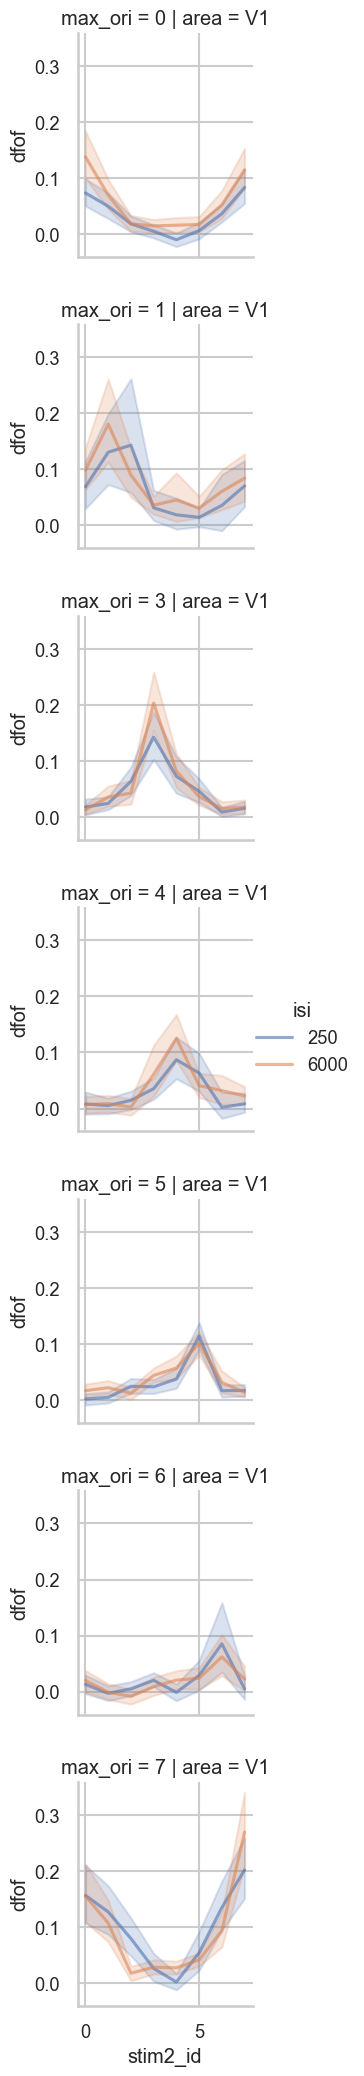

In [324]:
sns.set(font_scale=0.8, context='talk', style='whitegrid')
g = sns.FacetGrid(df_filter, col="area", row="max_ori", hue="isi")
g.map_dataframe(sns.lineplot, x="stim2_id", y="dfof", alpha=0.6)
g.figure.subplots_adjust(wspace=0.4, hspace=0.3)
g.add_legend();

# san check
what can generate possibly fake adp when adapter vs target are orthogonal?  
check if bin=90 tuning curve is real: plot timecourse for stim2=90, noad vs 250

In [ ]:
df_lineplot[df_lineplot.area == 'V1'].groupby(['date', 'sess']).cell_id.nunique() # 201209-sess002 has highest ncell for V1 data
# 210120 & 201015 has the most outrageous adp at stim2=90. let's try use 210120

date    sess
200720  003     103
200728  003      93
200803  002      97
201015  004      82
201209  002     146
210120  003      62
Name: cell_id, dtype: int64

In [335]:
df_test = df_lineplot[(df_lineplot.date == '210120')] # use this date and sess for sanity check
df_test.cell_id = df_test.cell_id.apply(lambda x: x.split('_')[-1]) # temporarily remove date from cell_id
df_test

C:\Users\ll357\AppData\Local\Temp\6\ipykernel_43944\1917010594.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.cell_id = df_test.cell_id.apply(lambda x: x.split('_')[-1]) # temporarily remove date from cell_id


,dfof,cell_id,area,filter_cell_vis,resp_id,isi,stim2_id,ori_mod,max_ori,max_ori_dist,date,sess
241305,-0.059959,0,V1,True,R2,250,4,False,1,22.5,210120,003
241306,-0.066803,0,V1,True,R2,250,3,False,1,22.5,210120,003
241307,0.055740,0,V1,True,R2,6000,4,False,1,22.5,210120,003
241308,-0.104743,0,V1,True,R2,250,0,False,1,22.5,210120,003
241309,0.035202,0,V1,True,R2,750,4,False,1,22.5,210120,003
...,...,...,...,...,...,...,...,...,...,...,...,...
270068,-0.015048,61,V1,True,R2,250,5,True,6,45.0,210120,003
270069,0.027682,61,V1,True,R2,750,2,True,6,45.0,210120,003
270070,0.091247,61,V1,True,R2,750,1,True,6,45.0,210120,003
270071,-0.030568,61,V1,True,R2,250,0,True,6,45.0,210120,003


In [359]:
df_filter = df_test[(df_test.filter_cell_vis == True)
                    & (df_test.ori_mod == True)
                    & (df_test.isi != 750)
                    ]
df_filter.cell_id.nunique(), df_test.cell_id.nunique()

cell_id_bool = pd.DataFrame(df_test.cell_id.astype(int).unique()).isin(df_filter.cell_id.astype(int).unique())
cell_id_bool.head(20) # whether this cell passes the filter (vis and ori_mod)
cell_id_bool = cell_id_bool.values.astype(int).flatten()
cell_id_bool

import scipy.io as sio
dir_mat = r'C:\Users\ll357\Documents\inter\results\tuning curve bias san check/'.replace('\\', '/')
sio.savemat(dir_mat+'vis_orimod_cell_bool.mat', {'vis_orimod_cell_bool': cell_id_bool})